In [ ]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [27]:
import time
from collections import OrderedDict
from evaluation_dataset import *
dataset = EvaluationDataset(count=LABEL_COUNT)

class EvaluationModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    layers = []
    for i in range(layer_count-1):
      layers.append((f"linear-{i}", nn.Linear(808, 808)))
      layers.append((f"relu-{i}", nn.ReLU()))
    layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT)
    return DataLoader(dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

configs = [
           {"layer_count": 4, "batch_size": 512},
          #  {"layer_count": 6, "batch_size": 1024},
           ]
for config in configs:
  version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
  logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
  trainer = pl.Trainer(gpus=1,precision=16,max_epochs=1,auto_lr_find=True,logger=logger, accelerator='mps')
  model = EvaluationModel(layer_count=config["layer_count"],batch_size=config["batch_size"],learning_rate=1e-3)
  # trainer.tune(model)
  # lr_finder = trainer.tuner.lr_find(model, min_lr=1e-6, max_lr=1e-3, num_training=25)
  # fig = lr_finder.plot(suggest=True)
  # fig.show()
  trainer.fit(model)
  break

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 2.0 M 
------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
3.924     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/72588 [00:00<?, ?it/s] 37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='
37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='
Epoch 0: 100%|██████████| 72588/72588 [3:51:52<00:00,  5.22it/s, loss=1.62, v_num=nt-4]  

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72588/72588 [3:51:53<00:00,  5.22it/s, loss=1.62, v_num=nt-4]


Idx 34545028 Eval 2.83 Prediction 3.71 Loss 0.88
FEN 3r3b/1pk4p/p1p1R1pB/8/1PP2P2/4P3/P5PP/2K5 b - b3 0 24


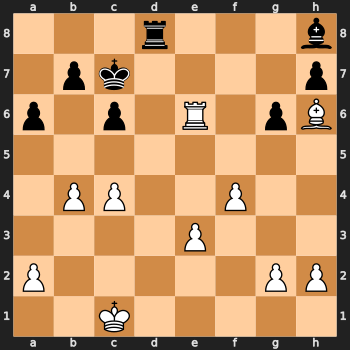

Idx 22760968 Eval 6.88 Prediction 4.64 Loss 2.24
FEN 4r1k1/3b1rqp/2p2p2/pp3P1B/3pPR2/3P2Q1/PPP3PP/R5K1 b - - 4 21


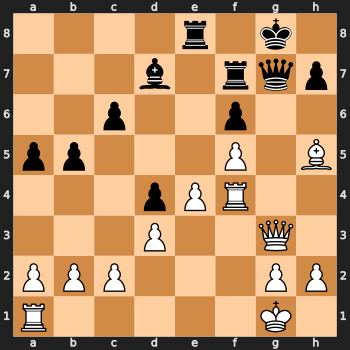

Idx 3207439 Eval -11.73 Prediction -4.35 Loss 7.38
FEN 8/1p4Q1/1kb4p/8/8/7P/6PK/5q2 b - - 28 65


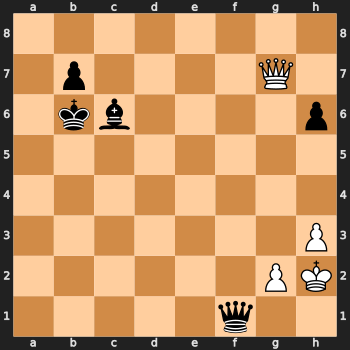

Idx 25860531 Eval 0.57 Prediction 0.80 Loss 0.23
FEN rn1qk1nr/1pp1ppbp/p2p2p1/8/2PPP1b1/2N2N2/PP2BPPP/R1BQK2R b KQkq - 3 6


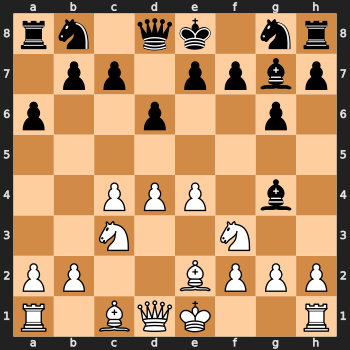

Idx 30521971 Eval 2.75 Prediction 0.70 Loss 2.05
FEN r2r2k1/1b3pp1/p3p1np/1pq5/3N4/P2Q2N1/BPP2PPP/3RR1K1 b - - 0 24


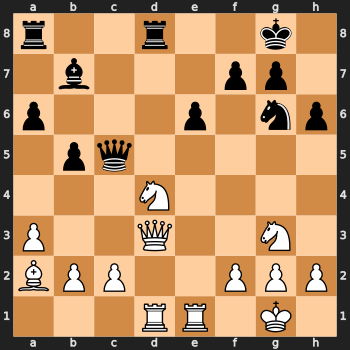

In [48]:
from IPython.display import display, SVG
from random import randrange
import chess
import chess.svg

# SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

# def svg_url(fen):
#   fen_board = fen.split()[0]
#   return SVG_BASE_URL + fen_board

def show_index(idx):
  # import pdb
  # pdb.set_trace()
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  board = chess.Board(eval.fen)
  display(chess.svg.board(board, size=350))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# need to do better on "tactics" like 700756

In [86]:
import torch
import chess

def fen_to_808bits(fen):
    board_obj = chess.Board(fen)  # Create a chess.Board object
    turn = board_obj.turn
    castling = board_obj.castling_rights
    en_passant = board_obj.ep_square
    bitstring = ''
    
    # Encode board state
    for piece_type in chess.PIECE_TYPES:
        for color in [True, False]:  # True for White, False for Black
            # bitboard = chess.SquareSet(chess.BB_SQUARES)
            bitboard = board_obj.pieces(piece_type, color)
            bitstring += format(int(bitboard), '064b')  # 64-bit representation

    # Encode active color, 1 bit (1 for White, 0 for Black)
    bitstring += '1' if turn else '0'

    # Encode castling rights, 4 bits (KQkq)
    c_rights = [bool(castling & chess.BB_A1),
                bool(castling & chess.BB_H1),
                bool(castling & chess.BB_A8),
                bool(castling & chess.BB_H8)]

    bitstring += ''.join(['1' if state else '0' for state in c_rights])

    # Encode en passant possibility, 1 bit (1 if possible, 0 otherwise)
    bitstring += '1' if en_passant else '0'

    # Use remaining 34 bits for other game states (for demonstration, filling with zeros)
    bitstring += '0' * 34

    # Convert bitstring to PyTorch tensor of floats
    tensor = torch.tensor([float(bit) for bit in bitstring])

    return tensor

tensor = fen_to_808bits(chess.Board().fen())
print(tensor.shape)


torch.Size([808])


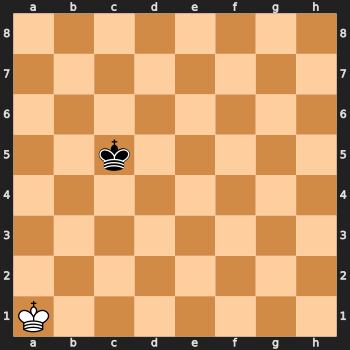

Draw due to insufficient material


In [93]:
from IPython.display import display, clear_output
from random import randrange
import chess
import chess.svg

board = chess.Board("8/7P/k7/8/8/8/8/K7 w - - 0 1")
display(chess.svg.board(board, size=350))

while not board.is_game_over():
    if board.turn == chess.WHITE:
        # Your move logic here
        user_input_valid = False
        while not user_input_valid:
            user_move = input("Enter your move (e.g., 'e2e4'): ")
            if len(user_move) == 4 or len(user_move) == 5:
                try:
                    move = chess.Move.from_uci(user_move)
                    if move in board.legal_moves:
                        user_input_valid = True
                    else:
                        print("Illegal move. Try again.")
                except:
                    print("Invalid input. Try again.")
            else:
                print("Input must be 4 characters long. Try again.")
    else:
        # AI logic
        max_value = -float('inf')  # Initialize to positive infinity
        best_move = None

        for move in board.legal_moves:
            board.push(move)
            
            # Convert board state to FEN, then to 808-bit tensor
            fen = board.fen()
            input_tensor = fen_to_808bits(fen)

            # Evaluate board state using neural network
            with torch.no_grad():
                output = model(input_tensor)  # Assuming model expects a batch dimension

            # Update the best move if this move has a lower evaluation value
            if output.item() > max_value:
                max_value = output.item()
                best_move = move

            board.pop()  # Undo the move to return to the original state

        move = best_move

    # Execute move and update board
    board.push(move)
    clear_output(wait=True)  # Clear the old board
    display(chess.svg.board(board, size=350))

# After the loop, you can check the game's outcome
if board.is_checkmate():
    print("Checkmate")
elif board.is_stalemate():
    print("Stalemate")
elif board.is_insufficient_material():
    print("Draw due to insufficient material")
elif board.is_seventyfive_moves():
    print("Draw due to 75-move rule")
elif board.is_fivefold_repetition():
    print("Draw due to fivefold repetition")
elif board.is_variant_draw():
    print("Draw due to variant-specific rules")
else:
    print("Draw due to fifty-move rule or threefold repetition")


In [ ]:
import chess

MATERIAL_LOOKUP = {chess.KING:0,chess.QUEEN:9,chess.ROOK:5,chess.BISHOP:3,chess.KNIGHT:3,chess.PAWN:1}

def avg(lst):
    return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type] 
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval
  
def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx))
print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')